In [1]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

import scvi
from scvi.model import TOTALVI



import anndata
import scanpy as sc

from scipy.stats import pearsonr, spearmanr

scvi.settings.seed = 0

save_path = "/Users/sagniknandy/Library/CloudStorage/Dropbox/PhD Projects/Current_Projects_with_Seniors/AMP+Multimodal_Data/Data_codes_cmp_norm/Cite_seq_detailed_ablation/"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%load_ext autoreload
%autoreload 2
%matplotlib inline

#import rpy2.rinterface_lib.callbacks
import logging

# from rpy2.robjects.packages import importr
# base = importr('base')
# utils = importr('utils')

# Matrix = importr('Matrix')
# seurat = importr('Seurat')
# stats = importr('stats')

/Users/sagniknandy/miniconda3/envs/AMP_all_projects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


In [2]:
sns.set(context="notebook", font_scale=1.3, style="ticks")
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True

sc.settings._vector_friendly = True
DPI = 300

import matplotlib.colors

In [3]:
np.random.seed(10)

In [4]:
meta_raw = pd.read_csv('meta.csv', low_memory=False)
meta_raw = meta_raw.T
meta = pd.DataFrame(meta_raw[10:11])

In [5]:
# Take the 6th column by position (0-based index -> column #5)
lane_series = meta_raw.iloc[5,:].copy()
lane_series.name = "lane"
n = len(lane_series)
lane_series.index = pd.Index([f"p {i}" for i in range(1, n + 1)], name="id")

In [6]:
adata = sc.read_h5ad(os.path.join(save_path, "data_cite_seq.h5ad"))

# Make sure it's a DataFrame (easier to track names)
if not isinstance(adata.obsm["protein_expression"], pd.DataFrame):
    prot_expr = pd.DataFrame(
        adata.obsm["protein_expression"],
        index=adata.obs_names,
        columns=adata.uns.get("protein_names", [f"prot{i}" for i in range(adata.obsm["protein_expression"].shape[1])])
    )
else:
    prot_expr = adata.obsm["protein_expression"]

# Compute variance (or other dispersion metric)
variances = prot_expr.var(axis=0)

# Select top 30 proteins
top30_proteins = variances.sort_values(ascending=False).head(30).index.tolist()

# Subset the protein expression matrix to those proteins
adata.obsm["protein_expression"] = prot_expr[top30_proteins]
adata.obs["lane"] = lane_series

In [7]:
# Clean up cell types (remove newlines, make categorical)
if "cell_types" in adata.obs:
    adata.obs["cell_types"] = (
        adata.obs["cell_types"].astype(str).str.replace("\n", "", regex=False)
    ).astype("category")

# Ensure protein matrix is present and float32
prot_key = "protein_expression"
if prot_key not in adata.obsm:
    raise KeyError(
        f"Expected adata.obsm['{prot_key}'] to hold the protein counts/matrix."
    )
adata.obsm[prot_key] = adata.obsm[prot_key].astype(np.float32)

# If protein names are stored in .uns['protein_names'], attach them as DataFrame columns
if "protein_names" in adata.uns:
    prot_names = np.asarray(adata.uns["protein_names"])
    if adata.obsm[prot_key].shape[1] == prot_names.size:
        adata.obsm[prot_key] = pd.DataFrame(
            adata.obsm[prot_key],
            index=adata.obs_names,
            columns=prot_names,
        )


In [8]:
# Gene names are already in adata.var_names; just ensure uniqueness
adata.var_names_make_unique()

# Optional: set a batch key if you have one (e.g., 'batch' or 'lane')
batch_key = "lane" if "lane" in adata.obs else None

# Reproducibility
scvi.settings.seed = 0

# Tell scvi-tools where RNA and protein live
TOTALVI.setup_anndata(
    adata,
    batch_key=batch_key,                       # or None if no batches
    protein_expression_obsm_key=prot_key,
    layer=None,                                # set to "counts" if RNA counts are in adata.layers["counts"]
)

Seed set to 0


INFO     Using column names from columns of adata.obsm['protein_expression']                                       


/var/folders/65/jw71vym14hj75kpj4y9360qh0000gn/T/ipykernel_3149/647622418.py:11: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  TOTALVI.setup_anndata(


In [9]:
use_cuda = True
lr = 2e-3
n_param_latent = 45

model = TOTALVI(adata, n_latent=n_param_latent)

trainer_kwargs = {"accelerator": "gpu", "devices": 1} if use_cuda else {"accelerator": "cpu", "devices": 1}

plan_kwargs = {"lr": lr}  # <-- only optimizer args here

model.train(
    max_epochs=500,
    train_size=0.9,
    batch_size=256,
    validation_size=0.1,
    plan_kwargs=plan_kwargs,
    early_stopping=True,
    early_stopping_patience=45,
    reduce_lr_on_plateau=True,       # enable LR scheduler with defaults
    check_val_every_n_epoch=1,
    **trainer_kwargs,
)





INFO     Computing empirical prior initialization for protein background.                                          


/Users/sagniknandy/miniconda3/envs/AMP_all_projects/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sagniknandy/miniconda3/envs/AMP_all_projects/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/sagniknandy/miniconda3/envs/AMP_all_projects/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_con

Epoch 382/500:  76%|███████▋  | 382/500 [24:20<07:31,  3.82s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.57e+3]    
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1625.709. Signaling Trainer to stop.


/var/folders/65/jw71vym14hj75kpj4y9360qh0000gn/T/ipykernel_3149/2410581162.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(post_adata, key_added="leiden_totalVI_1.0", resolution=1.0)


Writing posterior AnnData to cite_seq.h5ad
Done.


/var/folders/65/jw71vym14hj75kpj4y9360qh0000gn/T/ipykernel_3149/2410581162.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


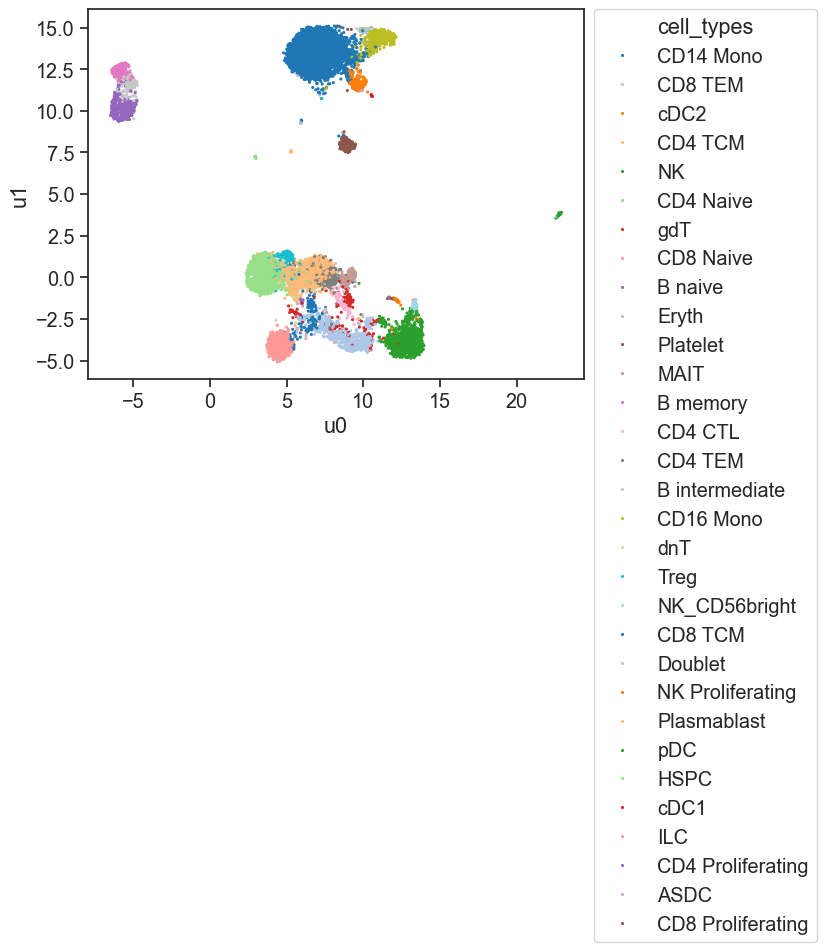

In [10]:
# ---- Posterior-like outputs (new API) ----
# Latent representation (n_cells x latent_dim)
latent_mean = model.get_latent_representation()

# Denoised expression (these return DataFrames indexed by cells; set `library_size` or `transform_batch` if desired)
# RNA:
rna, protein = model.get_normalized_expression(include_protein_background=True)

# ---- Save model weights / full artifacts ----
# (Saves model, trainer state, and anndata field registry into a folder)
model_dir = "cite_seq_totalvi_model"
model.save(model_dir, overwrite=True)

# If you also want raw torch weights as in your old code:
torch.save(model.module.state_dict(), "cite_seq.pt")

# ---- Build a posterior AnnData for downstream viz/clustering ----
post_adata = adata.copy()
post_adata.obsm["X_totalVI"] = latent_mean

# Neighbors/UMAP/Leiden (same as before)
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.3)
sc.tl.leiden(post_adata, key_added="leiden_totalVI_1.0", resolution=1.0)
sc.tl.leiden(post_adata, key_added="leiden_totalVI_0.8", resolution=0.8)
sc.tl.leiden(post_adata, key_added="leiden_totalVI_0.6", resolution=0.6)
sc.tl.leiden(post_adata, key_added="leiden_totalVI_0.4", resolution=0.4)

print("Writing posterior AnnData to cite_seq.h5ad")
post_adata.write("cite_seq.h5ad", compression="gzip")
print("Done.")

# ---- Export CSVs (UMAP + latent + labels) ----
# UMAP:
umap_df = pd.DataFrame(
    post_adata.obsm["X_umap"],
    index=post_adata.obs_names,
    columns=["u0", "u1"]
)
umap_df.to_csv("umap_post_save_cite_seq_tvi_75rpcs.csv")  # updated filename to reflect 65 latent dims

# Latent:
ltmean_df = pd.DataFrame(
    post_adata.obsm["X_totalVI"],
    index=post_adata.obs_names
)
ltmean_df.to_csv("latent_mean_citeseq_tvi_75rpcs.csv")

# Labels (replace 'cell_types' with your preferred obs column if different)
label_col = "cell_types" if "cell_types" in post_adata.obs else None
if label_col is not None:
    labels = post_adata.obs[label_col].astype(str).to_numpy()
else:
    labels = np.array(["unlabeled"] * post_adata.n_obs)

labels_df = pd.DataFrame({"label": labels}, index=post_adata.obs_names)
labels_df.to_csv("labels_citeseq_tvi_75rpcs.csv")

# ---- Quick UMAP scatter ----
umap_plot_df = umap_df.copy()
umap_plot_df["label"] = labels
sns.scatterplot(data=umap_plot_df, x="u0", y="u1", hue="label", palette="tab20", s=5, linewidth=0)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, title=label_col or "label")
plt.tight_layout()
plt.show()